In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.086565e+09,868,1.251802e+06,612.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.179460e+08,582,5.462989e+05,2036.5
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,9.947018e+07,589,1.688798e+05,250.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,9.866908e+07,122,8.087629e+05,117035.5
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,9.195982e+07,197,4.668011e+05,500.0
5,,C00571703,CHEVRON CORPORATION,koch industries inc koch industries inc,Y4000,,NaN,NaN,WASHINGTON,TX,6.460129e+07,212,3.047231e+05,50000.0
6,,C00495028,CHC BOLD PAC,chc bold pac chc bold pac,Z9600,,NaN,NaN,WASHINGTON,DC,5.408387e+07,207,2.612747e+05,70000.0
7,,C00693382,FUND FOR POLICY REFORM,fund for policy reform fund for policy reform,J1200,,NaN,NaN,WILMINGTON,DE,4.950000e+07,7,7.071429e+06,6000000.0
8,,C00669259,FUTURE FORWARD USA ACTION,future forward usa action future forward usa a...,J1200,,NaN,NaN,WASHINGTON,DC,4.526326e+07,27,1.676417e+06,100000.0
9,,C00504530,AMERICAN ACTION NETWORK,american action network american action network,Z9600,,NaN,NaN,WASHINGTON,DC,4.465169e+07,138,3.235630e+05,100000.0


In [4]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
6211,P00013524,N00011042,Jo Jorgensen (L),L,PRES,,Y,Y,C,3L
6278,P00014209,N00042370,Don Blankenship (3),3,PRES,,Y,Y,C,3L
6934,P80000722,N00001669,Joe Biden (D),D,PRES,,Y,Y,C,DW
6936,P80001571,N00023864,Donald Trump (R),R,PRES,PRES,Y,Y,I,RL


In [5]:
cands[cands["recip_id"].str.contains("N")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
0,H0AK00105,N00039029,Thomas Lamb (I),I,AK01,,,Y,C,3N
1,H0AK00113,N00047445,Ray Sean Tugatuk (D),D,AK01,,,Y,C,DL
3,H0AL01055,N00044245,Jerry Carl (R),R,AL01,,Y,Y,O,RW
4,H0AL01063,N00044288,Wes Lambert (R),R,AL01,,,Y,O,RL
5,H0AL01071,N00025369,Chris Pringle (R),R,AL01,,,Y,O,RL
...,...,...,...,...,...,...,...,...,...,...
8055,S8WV00135,N00041474,Bo Copley (R),R,WVS1,,,,,RN
8056,S8WV00143,N00012642,Patrick Morrisey (R),R,WVS1,,,,,RN
8057,S8WY00189,N00027793,Gary Trauner (D),D,WYS1,,,,,DN
8058,S8WY00197,N00042998,David Dodson (R),R,WYS1,,,,,RN


In [6]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Party                    1299587
Unknown                  1036328
Ideology/Single Issue     861610
Health                    541522
Finance                   443132
Tech                      224719
Law                       199207
Construction              122016
Transportation            118605
Labor                     112626
Energy                     89268
Agribusiness               73594
Manufacturing              55259
Defense                    37952
Name: count, dtype: int64

In [7]:
preds = pd.read_csv(pred_csv)
donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
donors = donors.merge(cands, on='recip_id', how='left')

In [8]:
contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,id,name_y,party,seat,seat_current,ran_general,ran_ever,type,recipcode,dem_ratio
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,P00014530,Michael Bloomberg (D),D,PRES,,,Y,C,DL,1.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,P00012716,Tom Steyer (D),D,PRES,,,Y,C,DL,1.0
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,P80000722,Joe Biden (D),D,PRES,,Y,Y,C,DW,1.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136705,h3001209792,N00040675,"GOULD, COLIN",colin gould,C5120,M,SOFTWARE INFRASTRUCTURE ARCHITECT,ORACLE,FOSTER CITY,CA,...,S8GA00180,Jon Ossoff (D),D,GAS1,,Y,Y,C,DW,1.0
7136706,p0001372401,C00003418,"BLEDSOE, PEARLIOUS MS",pearlious ms bledsoe,X1200,F,RETIRED,RETIRED,GRANITEVILLE,SC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7136707,r0006423692,C00003418,"CARMICHAEL, RUTH",ruth carmichael,X1200,F,RETIRED,RETIRED,KANSAS CITY,KS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7136708,r0015995400,C00003418,"BOOKATZ, DEBRA MRS",debra mrs bookatz,Y4000,F,RETIRED,MARINE CORP. COMMUNITY SERVICES,KANEOHE,HI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
donors[~(donors["name_y"].isna())].sort_values(by=['total_donated'], ascending=False).iloc[:10][["name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
0,michael r bloomberg,Z9000,M,FOUNDER,NEW YORK,NY,1.086565e+09,Michael Bloomberg (D),D,PRES,C,DL
1,tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SAN FRANCISCO,CA,3.179460e+08,Tom Steyer (D),D,PRES,C,DL
2,information information requested,Y4000,,NaN,NEW YORK,CA,9.947018e+07,Joe Biden (D),D,PRES,C,DW
12,ion republ puiu,Y4000,,NaN,KEW GARDENS,CA,3.708834e+07,Donald Trump (R),R,PRES,I,RL
68,kathaleen wall,Z9000,F,RETIRED,HOUSTON,TX,5.971223e+06,Kathaleen Wall (R),R,TX22,O,RO
78,darrell issa - personal funds,Z9000,M,NaN,VISTA,CA,5.081387e+06,Darrell Issa (R),R,CA50,O,RW
88,mrs kreibich,X1200,,NaN,DENVER,CO,4.834415e+06,Mitch McConnell (R),R,KYS1,I,RW
122,sara jacobs,Z9000,F,SCHOLAR IN RESIDENCE,SAN DIEGO,CA,2.970613e+06,Sara Jacobs (D),D,CA53,O,DW
188,david trone,Z9000,M,CONGRESSMAN,BETHESDA,MD,1.695000e+06,David Trone (D),D,MD06,I,DW
201,joseph p iii kennedy,Z9000,M,REPRESENTATIVE,FOXBORO,MA,1.505000e+06,Joe Kennedy III (D),D,MAS2,C,DL


In [10]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
277,h3003465387,shiva ayyadurai,Z9000,U,CHAIRMAN & CEO,BELMONT,MA,1044900.0,Shiva Ayyadurai (R),R,MAS2,C,RL
7869,m0002196589,pathmanath desilva,T7000,U,CEO,TAMPA,FL,61821.0,Donald Trump (R),R,PRES,I,RL
8796,q0002067764,satish chandra,H1100,N,PHYSIAN,NEW YORK,NY,52920.0,Donald Trump (R),R,PRES,I,RL
11254,b0060468773,donna karan,Z9500,F,DESIGNER,NEW YORK,NY,48200.0,Joe Biden (D),D,PRES,C,DW
11784,r0019991585,barjinderjit singh,Z9600,U,CPA,PACIFICA,CA,45000.0,Donald Trump (R),R,PRES,I,RL
13219,b0608510336@,nalini mathur,H5150,F,RETIRED,HOUSTON,TX,39782.0,Donald Trump (R),R,PRES,I,RL
18396,r0016936800,bangar reddy,F2100,F,NaN,SUGAR LAND,TX,31984.0,Bangar Reddy Aaloori (R),R,TX22,O,RL
19745,p0005411243,farid khan,Y4000,M,HOTELIER,GILLETTE,WY,29500.0,Donald Trump (R),R,PRES,I,RL
19950,q00019578621,pritesh gandhi,Z9000,M,PHYSICIAN,AUSTIN,TX,29184.0,Pritesh Gandhi (D),D,TX10,C,DL
20830,q0000681742,philip thakadiyil,Z9500,M,CFO,WILLOW SPRINGS,IL,27000.0,Elizabeth Warren (D),D,MAS1,I,DI


In [11]:
donors[~(donors["name_y"].isna())].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    1223
R    1187
I      62
3      37
L      36
U       2
Name: count, dtype: int64

In [12]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    567
R    392
I      6
L      3
3      2
Name: count, dtype: int64

In [13]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')[["recip_id", "name_y", "party", "seat"]]

,recip_id,name_y,party,seat
51249,N00041312,Omar Siddiqui (D),D,CA48
96273,N00038290,Jan McDowell (D),D,TX24
126142,N00031005,Vicky Hartzler (R),R,MO04
130450,N00045057,Beth Parlato (R),R,NY27
131516,N00037442,Neal Dunn (R),R,FL02
...,...,...,...,...
7134783,N00043581,Ilhan Omar (D),D,MN05
7134865,N00041334,Theresa Greenfield (D),D,IAS2
7135395,N00046489,Raphael Warnock (D),D,GAS2
7135969,N00040675,Jon Ossoff (D),D,GAS1


In [14]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind") & (donors["state"] == "WY")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
19745,p0005411243,farid khan,Y4000,M,HOTELIER,GILLETTE,WY,29500.0,Donald Trump (R),R,PRES,I,RL
264293,m00014288021,king husein,B1500,M,CHAIRMAN,JACKSON,WY,5600.0,Donald Trump (R),R,PRES,I,RL
567698,m00014288021,king mr husein,B1500,M,CHAIRMAN AND CEO,JACKSON,WY,2800.0,Liz Cheney (R),R,WY01,I,RW
587626,m00014288021,king husein,B4400,M,ENGINEER,JACKSON,WY,2800.0,Kelly Loeffler (R),R,GAS2,I,RL
594586,m0001428802@,diane mrs husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,Liz Cheney (R),R,WY01,I,RW
609198,r0014730623,dharmesh patel,Y3000,M,SELF EMPLOYED,SHERIDAN,WY,2800.0,Joe Biden (D),D,PRES,C,DW
611358,m0001428802@,diane husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,Kelly Loeffler (R),R,GAS2,I,RL
615039,m0001428802@,diane husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,David Perdue (R),R,GAS1,I,RL
633997,m00014288021,king husein,B4400,M,ENGINEER,JACKSON,WY,2800.0,David Perdue (R),R,GAS1,I,RL
4460840,m00014288021,king husein,B1500,M,FOUNDER / CEO,JACKSON,WY,250.0,TJ Cox (D),D,CA21,I,DL


In [15]:
# 2020: 5.8 billion vs 38.5 million
print("Overall:", donors[~(donors["name_y"].isna())]["total_donated"].sum())
print("Indians:", donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())

Overall: 5062218859.0
Indians: 31919209.0


In [16]:
print("Finance:", donors[(donors["sector"] == "Finance") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Finance, Indian:", donors[(donors["sector"] == "Finance") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Tech:", donors[(donors["sector"] == "Tech") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Tech, Indian:", donors[(donors["sector"] == "Tech") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Health:", donors[(donors["sector"] == "Health") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Healthm Indian:", donors[(donors["sector"] == "Health") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())

Finance: 331045881.0
Finance, Indian: 3026572.0
Tech: 123597963.0
Tech, Indian: 1356277.0
Health: 219160598.0
Healthm Indian: 3736030.0


In [19]:
donors["seat"].value_counts()

seat
PRES    1380460
VTS1     218123
SCS2     180918
GAS1     141360
MAS1     117380
         ...   
CAS2         54
NCS2         53
FL24         42
AS00         14
MP00         13
Name: count, Length: 541, dtype: int64

In [47]:
donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")
donors["level"].value_counts()

level
Unknown      3447415
Senate       1462833
President    1380460
House         846002
Name: count, dtype: int64

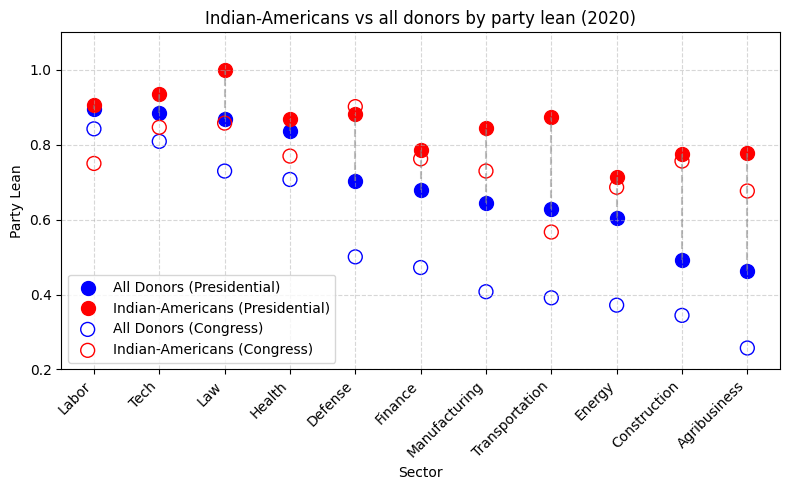

In [65]:
mean_all_pres = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "President")].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind_pres = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "President")][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all_pres.index
mean_ind_pres = mean_ind_pres.reindex(sectors, fill_value=0)

mean_all = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] != "President")].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] != "President")][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all.index
mean_ind = mean_ind.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, mean_all_pres, mean_ind_pres):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, mean_all_pres, color='blue', label='All Donors (Presidential)', s=100)
plt.scatter(sectors, mean_ind_pres, color='red', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, mean_all, facecolors='none', edgecolors='blue', label='All Donors (Congress)', s=100)
plt.scatter(sectors, mean_ind, facecolors='none', edgecolors='red', label='Indian-Americans (Congress)', s=100)

plt.title(f"Indian-Americans vs all donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.ylim([0.2, 1.1])
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(mean_all_pres).merge(pd.DataFrame(mean_ind_pres), left_index=True, right_index=True, suffixes=('_all_pres', '_ind_pres')).reset_index().rename(columns={'index': 'sector'})

,sector,dem_ratio_all,dem_ratio_ind
0,Law,0.896665,0.905172
1,Tech,0.884093,0.935217
2,Labor,0.869723,1.000000
3,Health,0.837369,0.868732
4,Finance,0.702968,0.883317
5,Defense,0.680043,0.785714
6,Manufacturing,0.645346,0.843404
7,Energy,0.627199,0.875000
8,Transportation,0.604625,0.713450
9,Construction,0.493229,0.774932


In [61]:
pd.DataFrame(mean_all).merge(pd.DataFrame(mean_ind), left_index=True, right_index=True, suffixes=('_all_cong', '_ind_cong')).reset_index().rename(columns={'index': 'sector'})

,sector,dem_ratio_all_cong,dem_ratio_ind_cong
0,Labor,0.842385,0.750000
1,Tech,0.808929,0.846498
2,Law,0.729692,0.857687
3,Health,0.707157,0.769686
4,Defense,0.500650,0.901701
5,Finance,0.472167,0.762297
6,Manufacturing,0.407626,0.729835
7,Transportation,0.391345,0.566941
8,Energy,0.371713,0.686385
9,Construction,0.344441,0.756418


In [52]:
print("Overall, presidential: ", mean_all_pres.mean())
print("Indians, presidential: ", mean_ind_pres.mean())
print("Overall, congressional: ", mean_all.mean())
print("Indians, congressional: ", mean_ind.mean())

Overall, presidential:  0.7004769064600379
Indians, presidential:  0.8511560617083892
Overall, congressional:  0.5303099216181536
Indians, congressional:  0.7549018227864422


In [66]:
state_stats = (
    donors.groupby(["state", "party", "level"])
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,party,level,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,NY,D,President,14006.397646,313.0,1.172265e+09,83695,1411.477051,500.0,1014852.0,719
1,CA,D,President,3202.577743,300.0,5.770533e+08,180184,1091.230061,500.0,1778705.0,1630
2,CA,D,Senate,994.275411,500.0,1.757710e+08,176783,1108.313517,500.0,1566047.0,1413
3,CA,D,House,1560.099169,500.0,1.451719e+08,93053,1836.509321,1000.0,2462759.0,1341
4,NY,D,House,1727.451214,1000.0,1.060672e+08,61401,1937.088921,1000.0,1328843.0,686
5,NY,D,Senate,1241.539142,500.0,1.028317e+08,82826,1653.476261,555.0,1114443.0,674
6,CA,R,President,1661.610415,375.0,9.460379e+07,56935,1547.684211,500.0,382278.0,247
7,TX,R,House,1185.211710,440.0,6.083099e+07,51325,1503.647059,725.0,255620.0,170
8,MA,D,Senate,1076.623176,500.0,5.961047e+07,55368,1313.293893,500.0,344083.0,262
9,TX,R,President,1200.693129,475.0,5.363136e+07,44667,1762.257732,530.0,170939.0,97


In [67]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [68]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [69]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

In [80]:
state_pivot = state_stats.pivot(index=['state', 'level'], columns='party', values='total_donations').fillna(0)
state_pivot['total'] = state_pivot['D'] + state_pivot['R']
state_pivot['dem_ratio'] = state_pivot['D'] / state_pivot['total']

state_pivot_indian = state_stats.pivot(index=['state', 'level'], columns='party', values='total_donations_indian').fillna(0)
state_pivot_indian['total'] = state_pivot_indian['D'] + state_pivot_indian['R']
state_pivot_indian['dem_ratio'] = state_pivot_indian['D'] / state_pivot_indian['total']

ratio = gdf.merge(state_pivot.reset_index(), left_on=['state'], right_on=['state'], how='right')
ratio_indian = gdf.merge(state_pivot_indian.reset_index(), left_on=['state'], right_on=['state'], how='right')

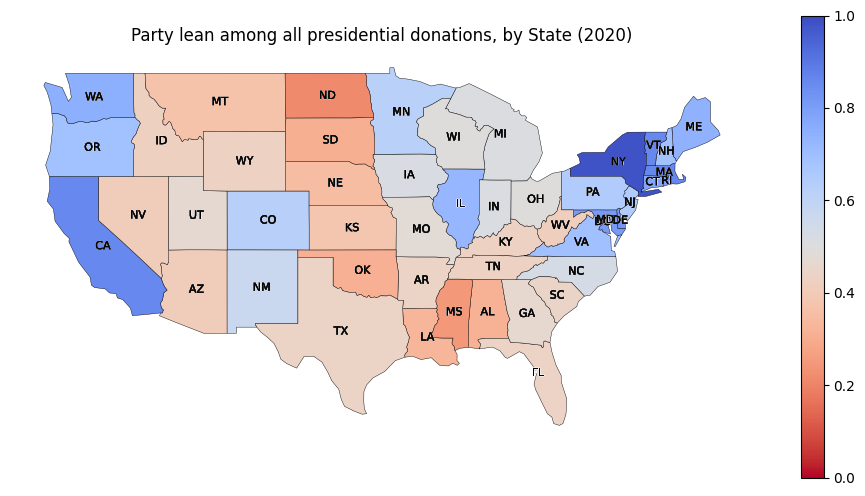

In [88]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] == "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all presidential donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [85]:
ratio[ratio["level"] == "President"][["state", "total"]].sort_values(by="total", ascending=False).head(10)

,state,total
147,NY,1.190993e+09
36,CA,6.716571e+08
192,TX,9.594286e+07
52,FL,8.474718e+07
92,MA,4.545686e+07
207,WA,4.255091e+07
73,IL,3.926271e+07
162,PA,3.888604e+07
198,VA,3.863084e+07
95,MD,3.400428e+07


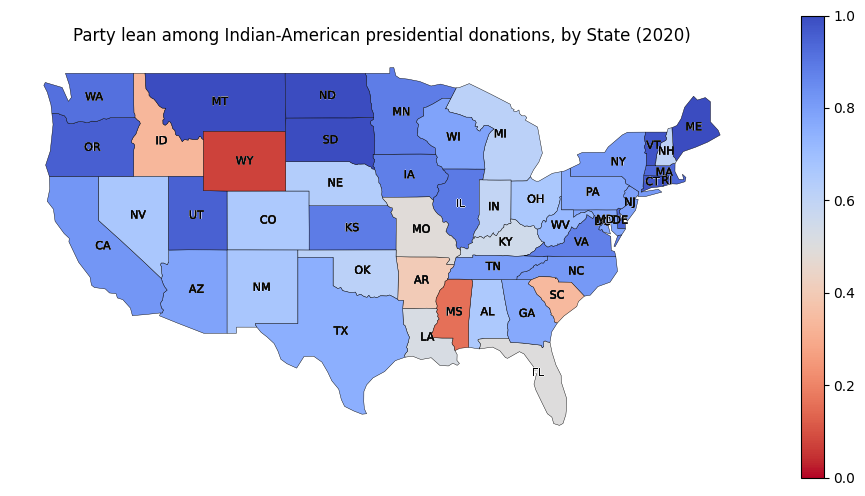

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian[ratio_indian["level"] == "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American presidential donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [90]:
ratio_indian[ratio_indian["level"] == "President"][["state", "total"]].sort_values(by="total", ascending=False).head(10)

,state,total
36,CA,2160983.0
147,NY,1254730.0
192,TX,693286.0
132,NJ,520397.0
52,FL,513748.0
198,VA,399624.0
73,IL,377141.0
95,MD,316232.0
92,MA,303927.0
207,WA,302254.0


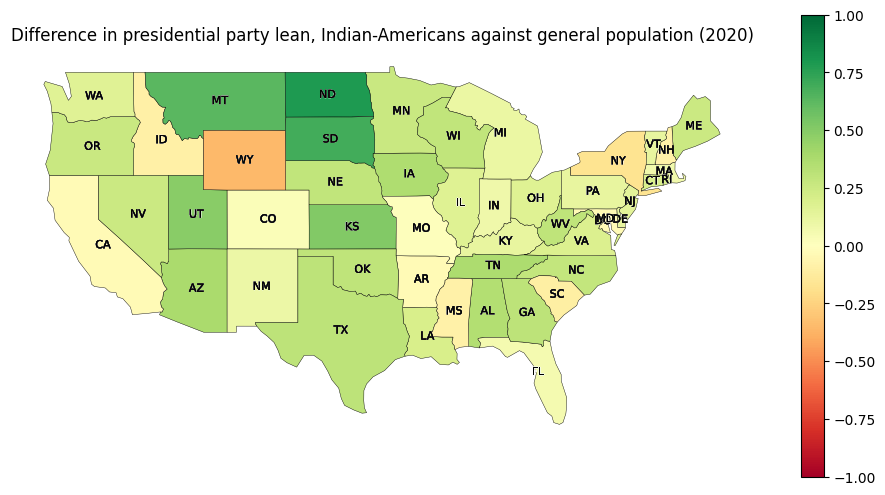

In [91]:
ratio["diff"] = ratio_indian["dem_ratio"] - ratio["dem_ratio"]

fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] == "President"].plot(
    column="diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in presidential party lean, Indian-Americans against general population (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

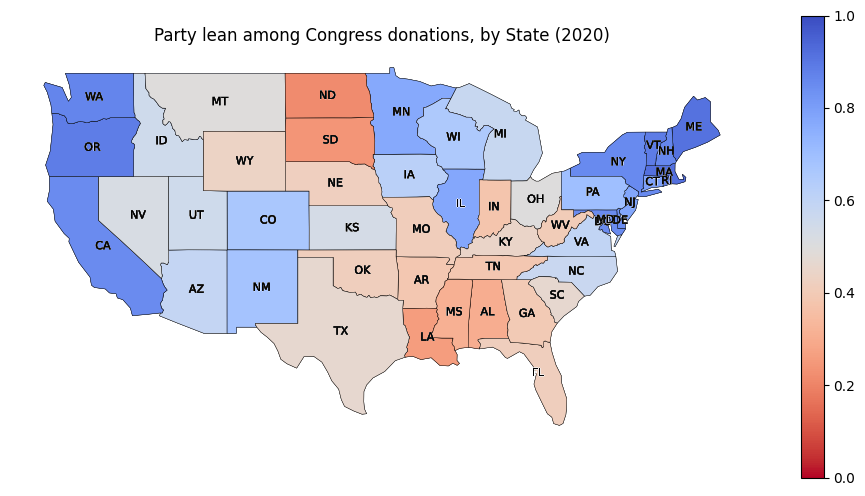

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] != "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all Congress donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [87]:
ratio[ratio["level"] != "President"][["state", "total", "level"]].sort_values(by="total", ascending=False).head(10)

,state,total,level
37,CA,206753125.0,Senate
35,CA,196216638.0,House
146,NY,126052920.0,House
148,NY,120604161.0,Senate
191,TX,104725165.0,House
193,TX,71705136.0,Senate
93,MA,65131432.0,Senate
51,FL,62901459.0,House
53,FL,55066572.0,Senate
40,CO,52387061.0,Senate


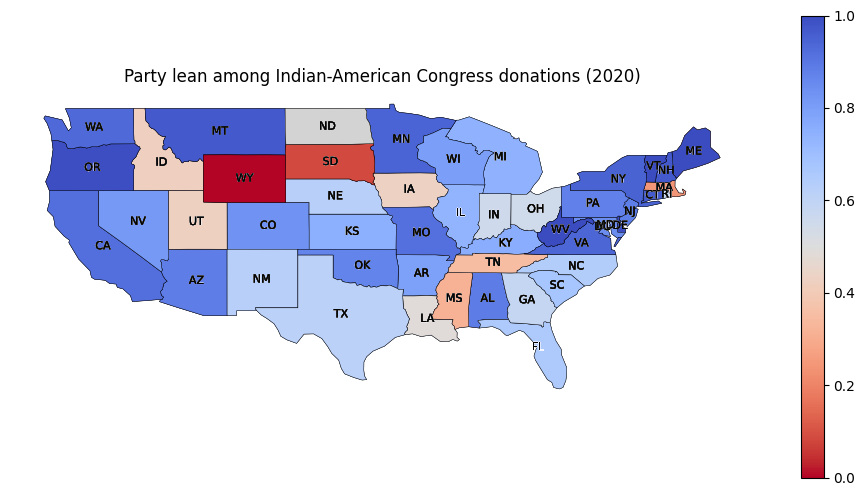

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian[ratio_indian["level"] != "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American Congress donations (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [95]:
ratio_indian[ratio_indian["level"] != "President"][["state", "total"]].sort_values(by="total", ascending=False).head(10)

,state,total
35,CA,2869062.0
37,CA,1700018.0
146,NY,1462743.0
93,MA,1440335.0
191,TX,1420784.0
148,NY,1177225.0
72,IL,1002476.0
131,NJ,728189.0
74,IL,604125.0
75,IN,592051.0


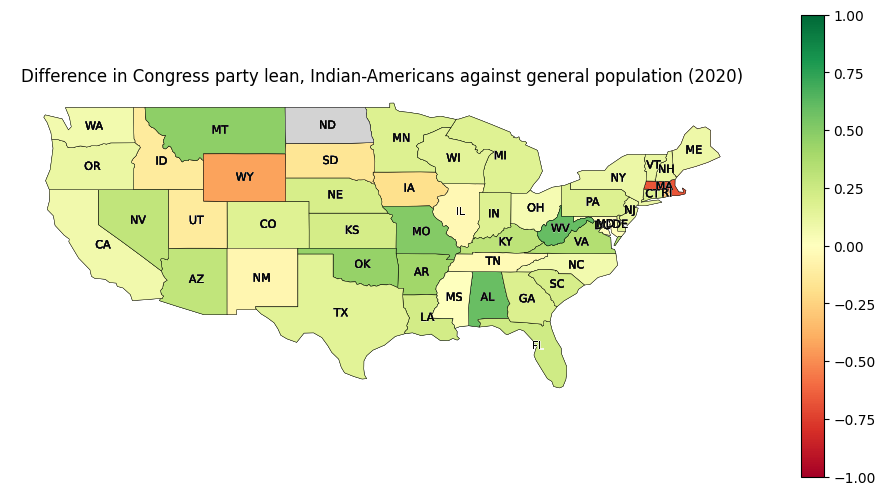

In [100]:
ratio["diff"] = ratio_indian["dem_ratio"] - ratio["dem_ratio"]

fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] != "President"].plot(
    column="diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in Congress party lean, Indian-Americans against general population (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()